# This notebook shows how to fit a resonator in the reflection configuration.

In [1]:
from __future__ import division, absolute_import, print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from resonator import background, reflection, see

Create data using the model plus gaussian noise. The model is the product of the reflection resonator model and a background model, which in this case assumes that the magnitude and phase are independent of frequency.

In [52]:
# Background parameters
background_model = background.ComplexConstant()
magnitude = 0.01
phase = -np.pi / 2

# Foreground parameters
foreground_model = reflection.ReflectionNonlinear(choose=np.max)
f_r = 1e9  # resonance frequency
df = 2e6  # frequency width
f = np.linspace(f_r - df / 2, f_r + df / 2, 501)
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000
KXin_critical = 3 ** (-3 / 2) * (internal_loss + coupling_loss) ** 3 / coupling_loss
print(KXin_critical)
KXin = -3 * KXin_critical
print(KXin)

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=f, magnitude=magnitude, phase=phase)
fg = foreground_model.func(frequency=f, resonance_frequency=f_r, internal_loss=internal_loss, coupling_loss=coupling_loss, KXin=KXin)

# The ideal data is the product of the background and foreground.
s21 = bg * fg

# The measured data will include noise
noise = 0.01 * magnitude
s21n = s21 + noise * (np.random.randn(s21.size) + 1j * np.random.randn(s21.size))

8.31384387633e-10
-2.4941531629e-09


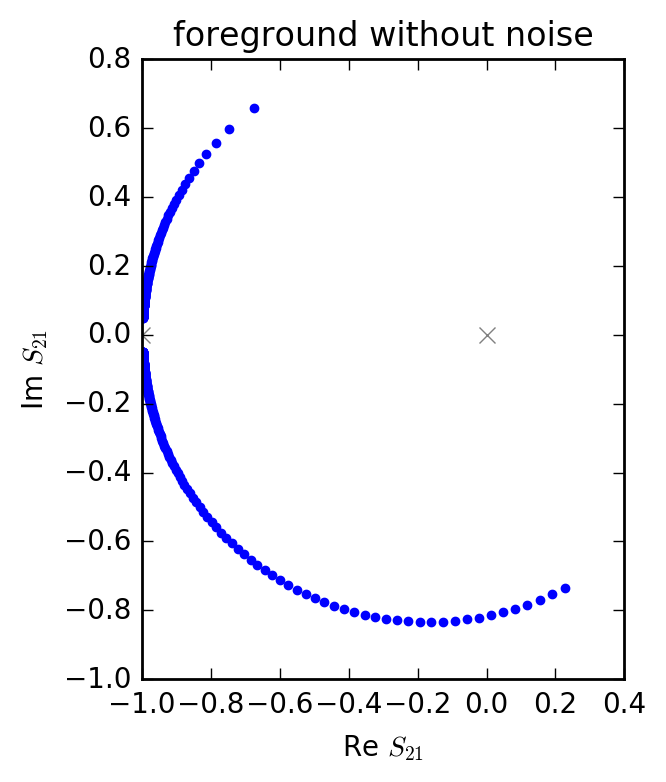

In [53]:
fig, ax = plt.subplots(dpi=200)
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(fg.real, fg.imag, '.')
ax.plot([0, -1], [0, 0], marker='x', linestyle='none', color='gray')
ax.set_title('foreground without noise');

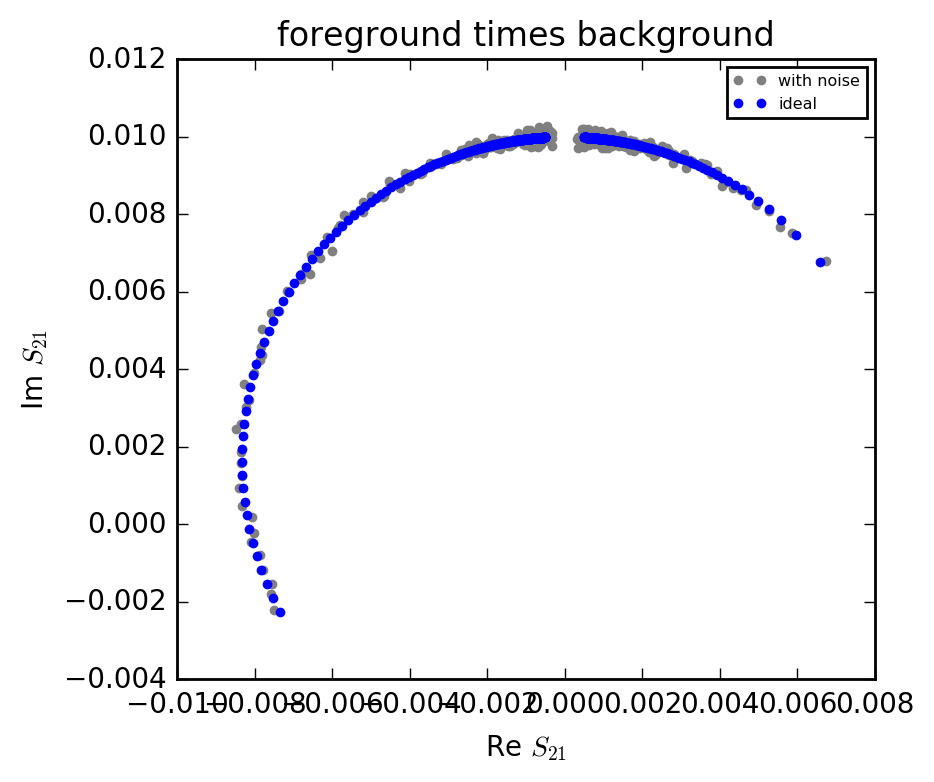

In [54]:
fig, ax = plt.subplots(dpi=200)
ax.set_aspect('equal')
ax.set_xlabel('Re $S_{21}$')
ax.set_ylabel('Im $S_{21}$')
ax.plot(s21n.real, s21n.imag, '.', color='gray', label='with noise')
ax.plot(s21.real, s21.imag, '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

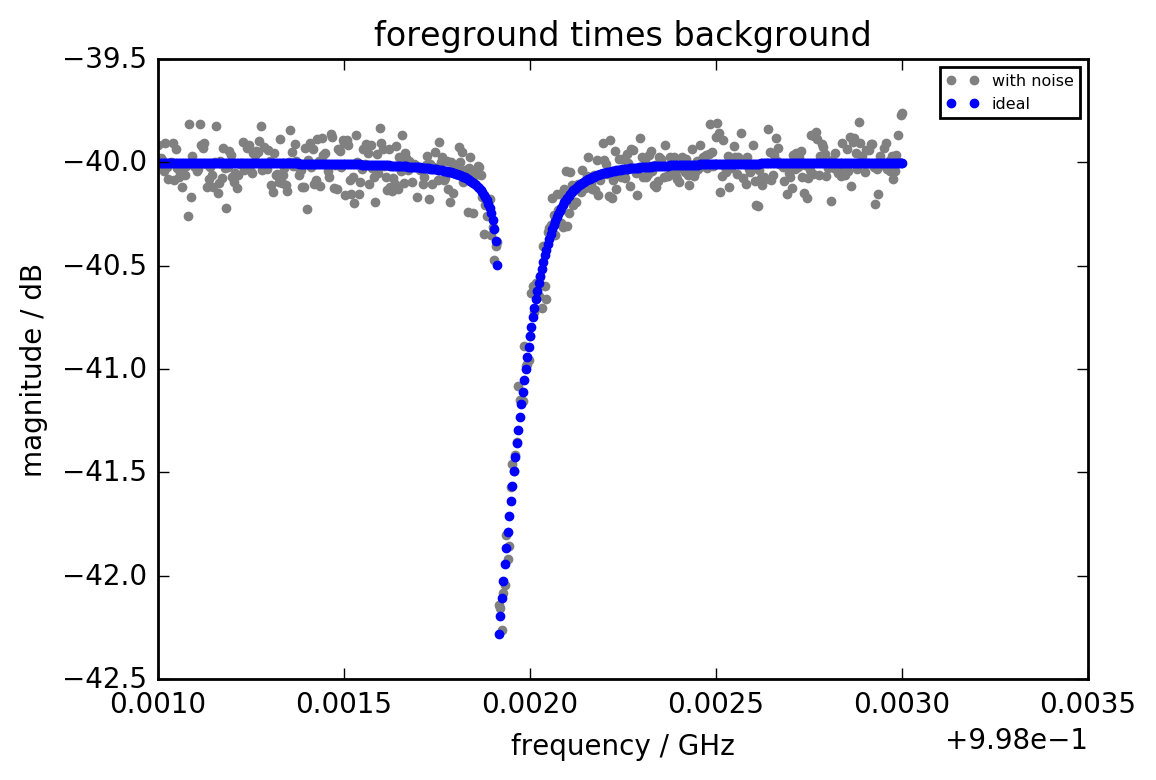

In [55]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('magnitude / dB')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21n)), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, 20 * np.log10(np.abs(s21)), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

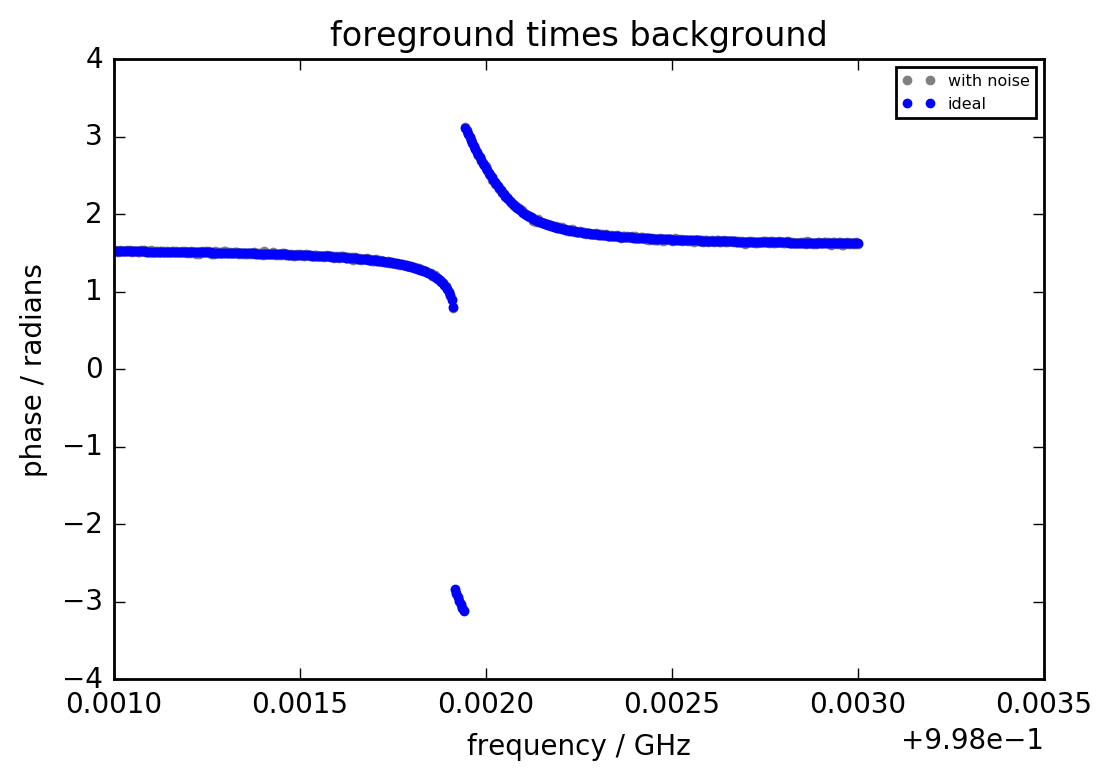

In [56]:
fig, ax = plt.subplots(dpi=200)
ax.set_xlabel('frequency / GHz')
ax.set_ylabel('phase / radians')
ax.plot(1e-9 * f, np.angle(s21n), '.', color='gray', label='with noise')
ax.plot(1e-9 * f, np.angle(s21), '.', label='ideal')
ax.legend(fontsize='xx-small')
ax.set_title('foreground times background');

## Fit the model to the data using a ReflectionNonlinearFitter.

Here, we know the standard error of each data point because we added the noise. If no errors are given, the fitting assumes equal errors for each point and thus equal weights, so errors are not generally necessary unless they vary between points.

In [57]:
resonator = reflection.ReflectionNonlinearFitter(frequency=f, data=s21n, errors=(1 + 1j) * noise * np.ones(f.size), choose=np.max)
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(complex_constant) * Model(reflection))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 1002
    # variables        = 6
    chi-square         = 963.196431
    reduced chi-square = 0.96706469
    Akaike info crit   = -27.5749040
    Bayesian info crit = 1.88361567
[[Variables]]
    magnitude:            0.00999772 +/- 4.6488e-06 (0.05%) (init = 0.01011197)
    phase:               -1.56893389 +/- 4.9349e-04 (0.03%) (init = -1.535731)
    resonance_frequency:  1.0000e+09 +/- 302.128026 (0.00%) (init = 9.9994e+08)
    internal_loss:        9.9411e-06 +/- 1.3813e-07 (1.39%) (init = 1.397038e-05)
    coupling_loss:        4.9841e-05 +/- 1.0799e-07 (0.22%) (init = 7.40349e-05)
    KXin:                -2.4807e-09 +/- 1.8796e-11 (0.76%) (init = 1e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(resonance_frequency, KXin)          = -0.827
    C(coupling_loss, KXin)                = -0.566
    C(inte

## How well do the fit values match the actual values, given the fit standard errors?

In [58]:
print("normalized deviation Q_i: {:.2f}".format(abs(resonator.Q_i - 1 / internal_loss) / resonator.Q_i_error))
print("normalized deviation Q_c: {:.2f}".format(abs(resonator.Q_c - 1 / coupling_loss) / resonator.Q_c_error))
print("normalized deviation f_r: {:.2f}".format(abs(resonator.f_r - f_r) / resonator.f_r_error))
print("normalized deviation magnitude: {:.2f}".format(abs(resonator.magnitude - magnitude) / resonator.magnitude_error))
print("normalized deviation phase: {:.2f}".format(abs(resonator.phase - phase) / resonator.phase_error))
print("normalized deviation KXin: {:.2f}".format(abs(resonator.KXin - KXin) / resonator.KXin_error))

normalized deviation Q_i: 0.42
normalized deviation Q_c: 1.46
normalized deviation f_r: 1.18
normalized deviation magnitude: 0.49
normalized deviation phase: 3.77
normalized deviation KXin: 0.72


## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance.

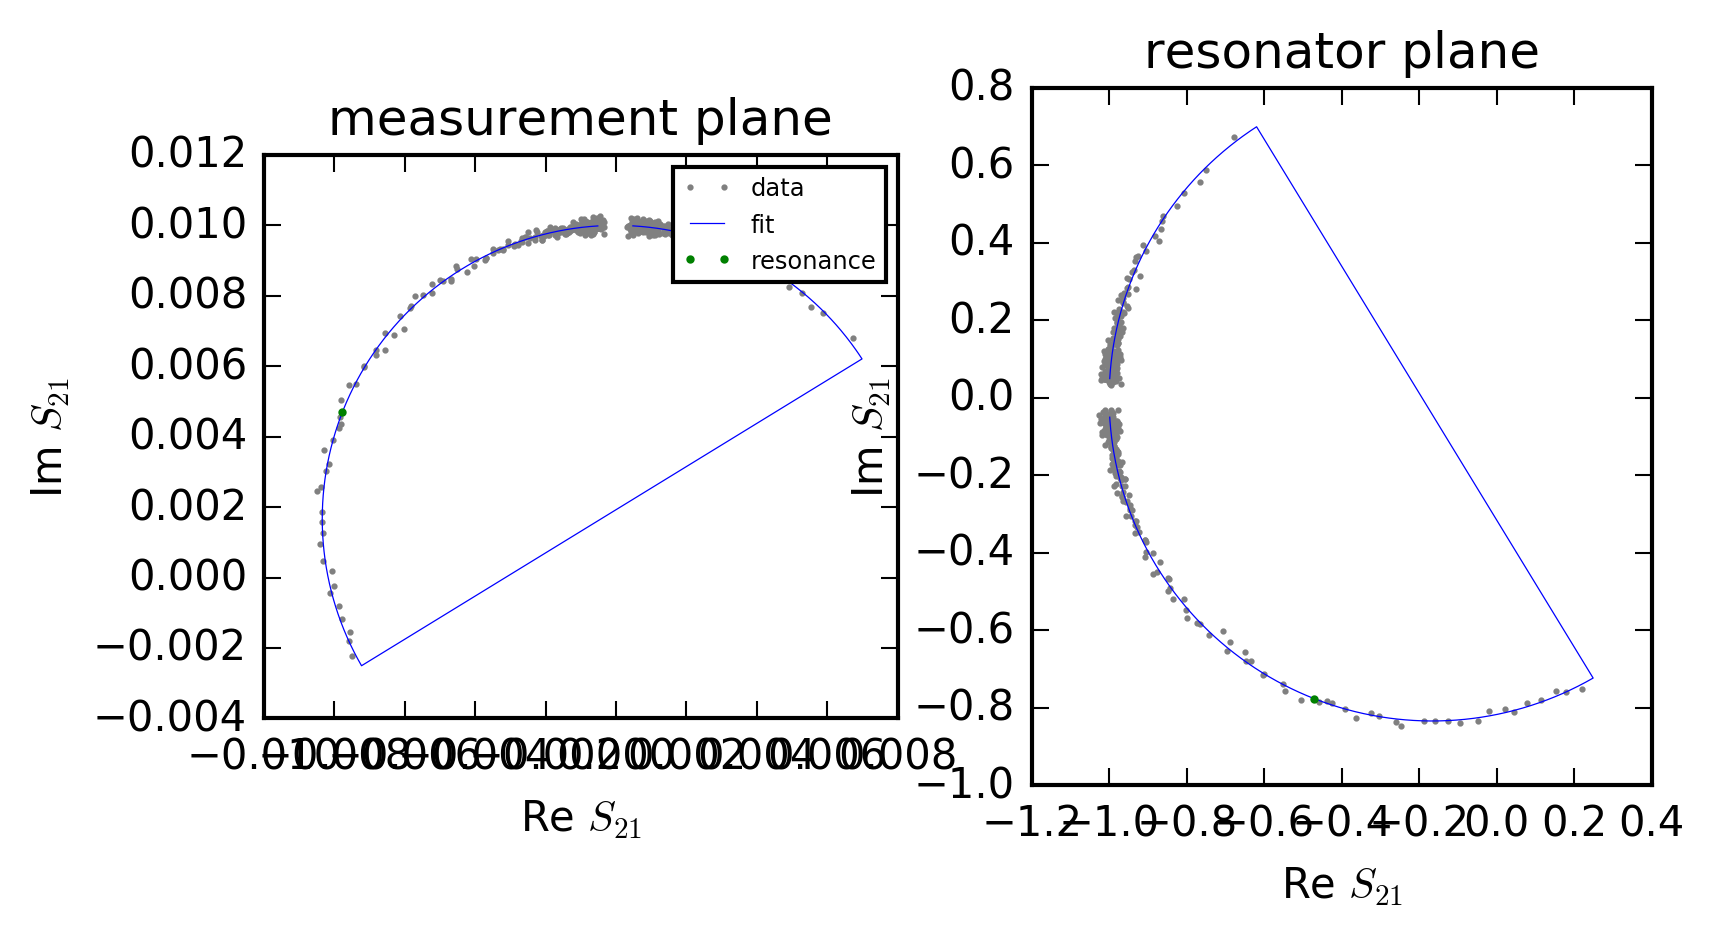

In [59]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
ax_raw.set_xlabel('Re $S_{21}$')
ax_raw.set_ylabel('Im $S_{21}$')
ax_norm.set_xlabel('Re $S_{21}$')
ax_norm.set_ylabel('Im $S_{21}$')
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');

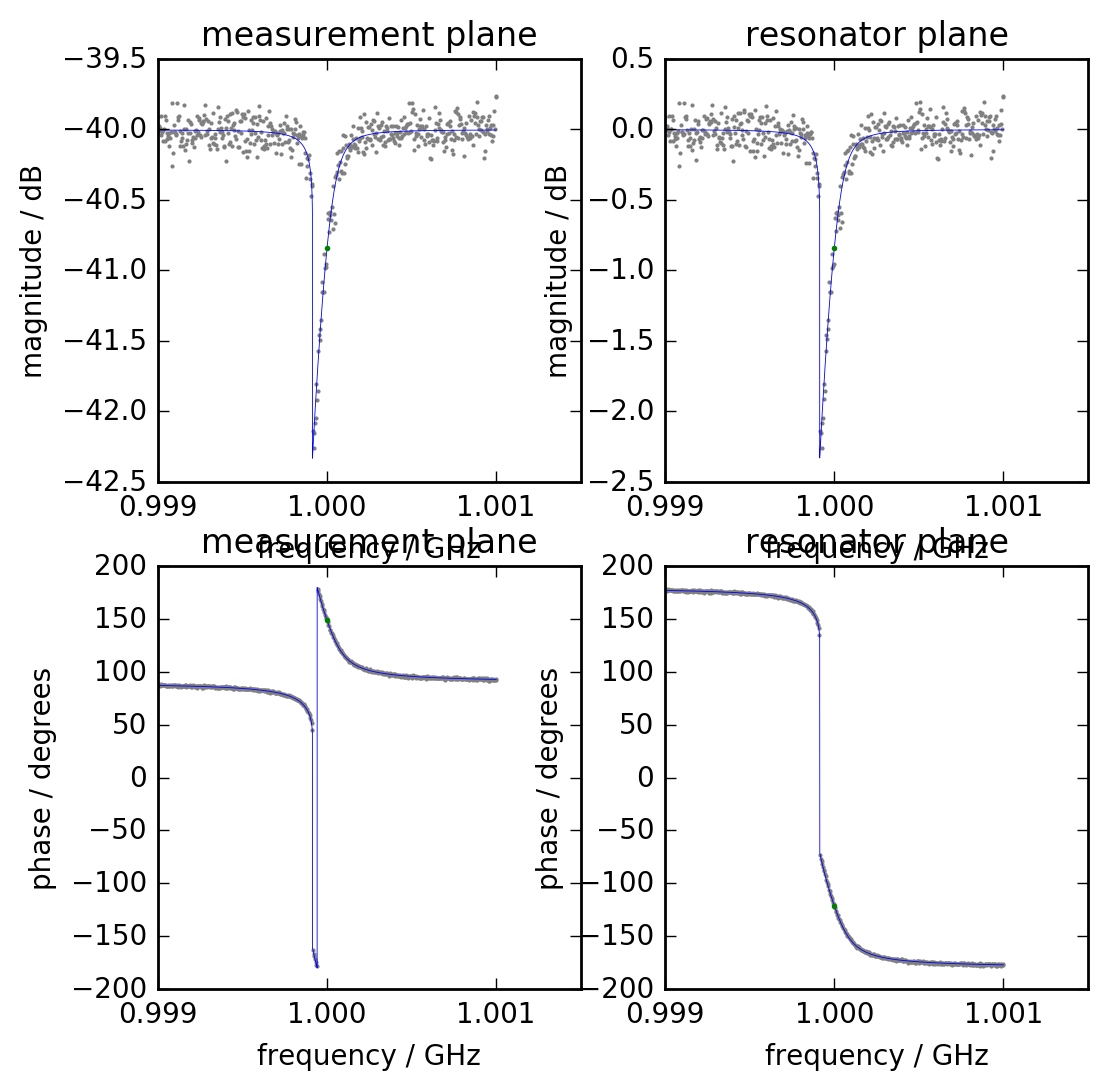

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=200)
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
ax_raw_mag.set_xlabel('frequency / GHz')
ax_norm_mag.set_xlabel('frequency / GHz')
ax_raw_phase.set_xlabel('frequency / GHz')
ax_norm_phase.set_xlabel('frequency / GHz')
ax_raw_mag.set_ylabel('magnitude / dB')
ax_norm_mag.set_ylabel('magnitude / dB')
ax_raw_phase.set_ylabel('phase / degrees')
ax_norm_phase.set_ylabel('phase / degrees')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);